<a href="https://colab.research.google.com/github/joaquinhojman/AprendizajeEstadistico-TPFinal/blob/main/Arboles_de_Decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
import pandas as pd
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve


from sklearn.model_selection import train_test_split

In [8]:
#Cargo el set de datos
url = 'https://raw.githubusercontent.com/joaquinhojman/AprendizajeEstadistico-TPFinal/main/heart.csv'

heart_csv = pd.read_csv(url)
heart_csv

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [40]:
#Se convierten variables a categorico y encode (Leo)

heart_csv['target'] = heart_csv['target'].astype('category')
heart_csv['sex'] = heart_csv['sex'].astype('category')
heart_csv['cp'] = heart_csv['cp'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['restecg'] = heart_csv['restecg'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['exang'] = heart_csv['exang'].astype('category')
heart_csv['slope'] = heart_csv['slope'].astype('category')
heart_csv['ca'] = heart_csv['ca'].astype('category')
heart_csv['thal'] = heart_csv['thal'].astype('category')

dummy_heart = pd.get_dummies(heart_csv, columns=['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs', 'exang'], drop_first=True)

# split 70 / 30
X_train, X_test, y_train, y_test = train_test_split(dummy_heart.drop('target', axis=1), dummy_heart['target'], test_size = 0.3, random_state=23)

#Ahora ya se puede entrenar un modelo predictivo


##XGBoost como Regresor y haciendo "a mano" la clasificacion

In [75]:
#Instancio el regresor de XGBoost con 10 arboles

#Parametros iniciales medio a dedo, despues se pueden optimizar pero creo que no es el objetivo del tp

xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
#Y entreno
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [76]:
#Predigo y calculo el error. Uso logloss ---> mientras mas cercano a 0, mejor resultado (ademas la formula queda piolita en el informe)

preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.53514558666355

In [71]:
#Aumento a 100 el numero de arboles para predecir
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.37364763039635024

In [78]:
#Reduzco la profundidad hasta 4
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
logloss = log_loss(y_test, preds)
logloss

0.3599741377683541

K-Fold Cross Validation

In [79]:
#Convierto a DMatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

#Entreno 
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 4, 'alpha': 10, 'n_estimators': 100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    as_pandas=True, seed=123)

cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.245280,0.003017,0.245272,0.005998
1,0.235741,0.033003,0.259692,0.055770
2,0.214681,0.020862,0.245473,0.054089
3,0.207588,0.012672,0.264252,0.037690
4,0.200529,0.020823,0.240644,0.041906


In [80]:
#Error final:
print((cv_results["test-error-mean"]).tail(1))

8    0.217237
Name: test-error-mean, dtype: float64


Clasificando los resultados

In [81]:
def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

#si >0.5, es 1 (won). si <0.5, es 0 (lost)

prediccion_bin = [1 if i > .5 else 0 for i in preds]
prediccion_bin[:10]

metrics = metricas(y_test, prediccion_bin)
[print(i) for i in metrics]


[[32 12]
 [ 3 44]]
0.8351648351648352
              precision    recall  f1-score   support

           0       0.91      0.73      0.81        44
           1       0.79      0.94      0.85        47

    accuracy                           0.84        91
   macro avg       0.85      0.83      0.83        91
weighted avg       0.85      0.84      0.83        91



[None, None, None]

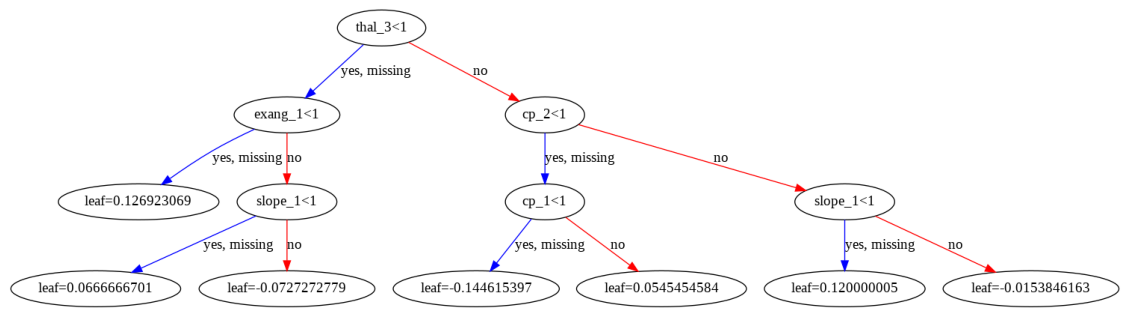

In [82]:
#Armo una visualizacion para el arbol
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_reg,num_trees=0)

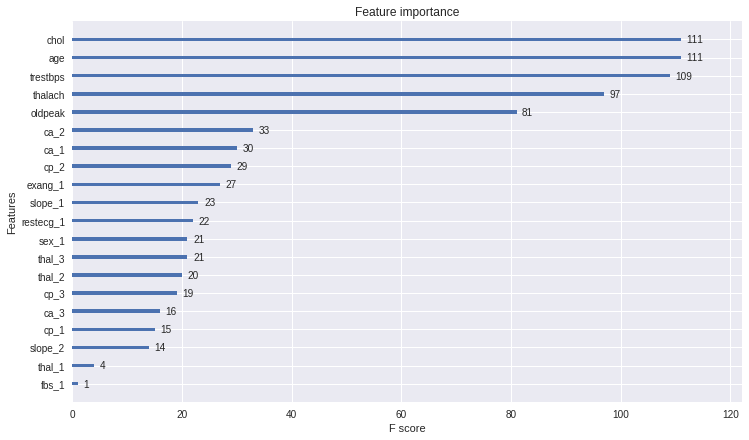

In [83]:
#Importancia de los features 
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)


##XGBoost como Clasificador

In [84]:
#Instancio el regresor de XGBoost con 10 arboles

xg_cls = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
#Y entreno
xg_cls.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
#Ahora no tiene sentido usar logloss como metrica. Uso Error Cuadratico Medio.
from sklearn.metrics import mean_squared_error

preds_cls = xg_cls.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_cls))
print("RMSE: %f" % (rmse))


RMSE: 0.456937


In [97]:
#Aumento el numero de arboles

xg_cls = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
#Y entreno
xg_cls.fit(X_train,y_train)

preds_cls = xg_cls.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_cls))
print("RMSE: %f" % (rmse))

RMSE: 0.377964


In [92]:
preds_cls

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1])

In [93]:
#Evaluacion del modelo:
def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metrics = metricas(y_test, preds_cls)
[print(i) for i in metrics]


[[33 11]
 [ 2 45]]
0.8571428571428571
              precision    recall  f1-score   support

           0       0.94      0.75      0.84        44
           1       0.80      0.96      0.87        47

    accuracy                           0.86        91
   macro avg       0.87      0.85      0.85        91
weighted avg       0.87      0.86      0.86        91



[None, None, None]

In [ ]:
#Rapidamente se puede observar que la precision es mejor de esta manera que usando el regresor y clasificando a mano.
#Tambien el accuracy, f1-score y el recall son mayores de esta manera.

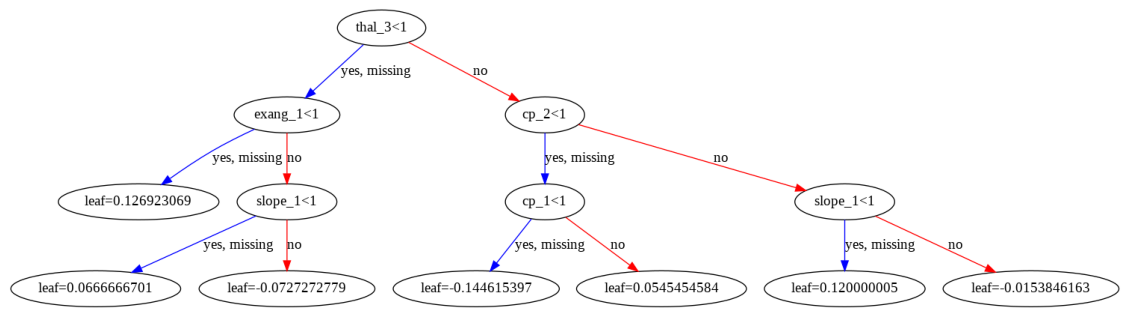

In [98]:
#Armo una visualizacion para el arbol
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_cls,num_trees=0)

#Observamos exactamente el mismo grafico que en el otro modelo (¿Por que?)

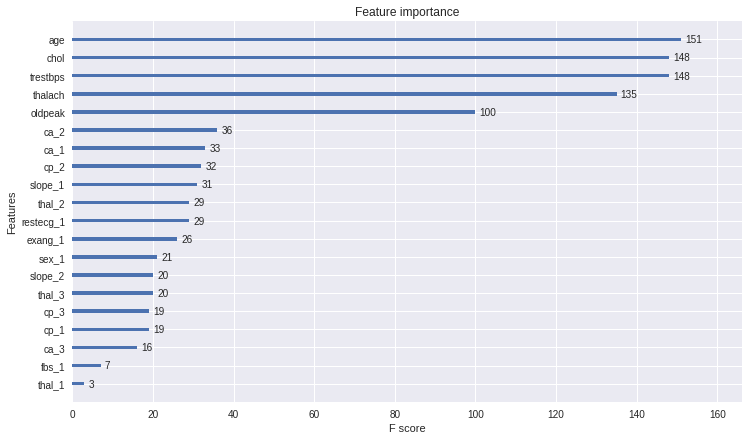

In [96]:
#Importancia de los features 
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_cls)

#Aca la importancia de cada feature es muy similar al otro modelo pero no igual

##Visualizaciones K-MEANS (cluster analysis)

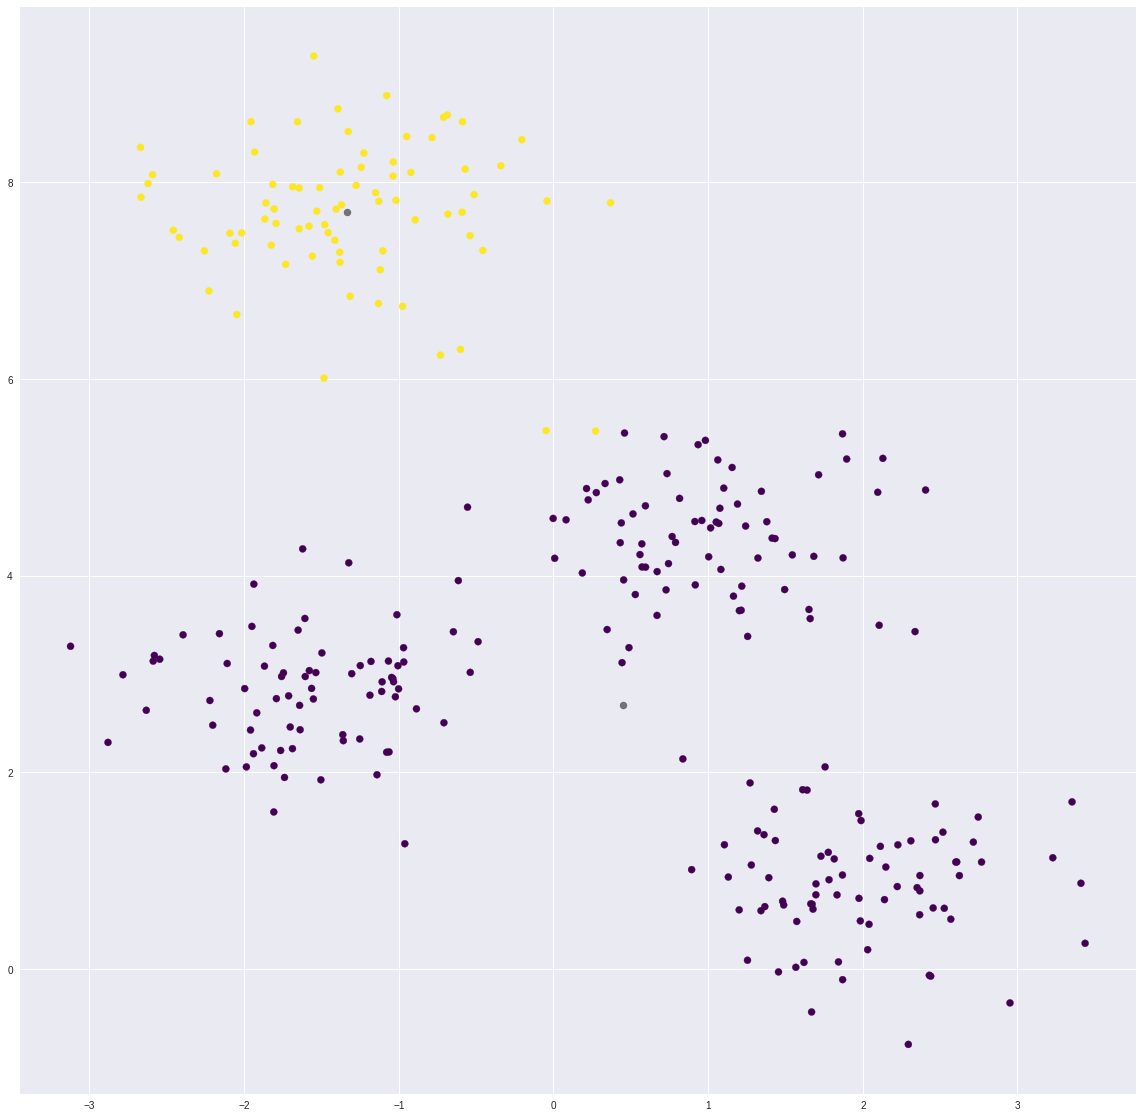

In [119]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2) #pongo 2 clusters, asumo 1 para target=1 y uno para target=0
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_train)


plt.scatter(X_train[:, 0], X_train[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5);
